## Univariate Stateful LSTM

The notebook picks up where the [notebook on grid search](https://github.com/anasashb/brent_price_forecasting/blob/main/univariate_lstm/1_tuning_stateful_lstm.ipynb) left off. 

Note that since the grid search served as validation also, in this notebook the 1 layer 45 unit LSTM network is directly fitted on the retrain set with predictions being generated subsequently on the test set. 

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.optimizers import Adam
import keras_tuner
import tensorflow as tf


# Seeds
tf.random.set_seed(66)
np.random.seed(66)

# Plot configurations
plt.rcParams['figure.figsize'] = (12, 6.75)
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 24

# Error metrics
def rmse(true, predicted):
    return np.sqrt(np.mean(np.square(predicted - true)))
def mape(true, predicted):
    true, predicted = np.array(true), np.array(predicted)
    return np.mean(np.abs((true - predicted) / true)) * 100




### **Data:**

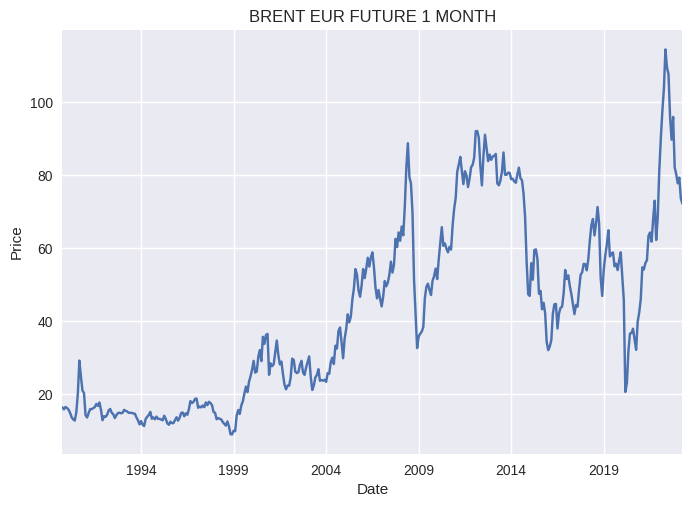

In [3]:
brentpath = '/home/RDC/anasashb/Dokumente/ECXLOC/BRENTDATA.csv'

# Import data set
BRENT = pd.read_csv(brentpath,
                   index_col = 'Date',
                   parse_dates = True)
BRENT = pd.Series(BRENT['EUR Future 1 Month'])

# Plot
BRENT.plot()
plt.title('BRENT EUR FUTURE 1 MONTH')
plt.ylabel('Price')
plt.show()

### **Pre-Processing for LSTM input**
Since in this case we'll be using the lag order of 1 and batch size of 1, input dimensions will not be a problem in terms of divisibility with the batch size. 

The set lengths are generated same as in the tuning notebook. 

In [4]:
dates = BRENT.index
series = BRENT.values.astype('float32').reshape(-1,1)

In [5]:
# Specify batch_size
batch_size = 1
# Specify lag order
timesteps = 1

In [6]:
# Set lengths
test_size = 81
val_size = 51
train_size = 271
print(test_size+val_size+train_size)

403


In [7]:
# Train-val-test split
train = series[:train_size]
val = series[train_size:train_size+val_size]
test = series[train_size+val_size:]

# Important to obtain the retrain set at this stage
# because we will lose observations if we concatenate 
# the sets after tensors have been generated
retrain = np.concatenate((train, val), axis = 0)
# Check
len(train)+len(val)==len(retrain)



True

In [8]:
# Scale and Generate Tensors

# Scaling: Use (-1,1) for better input to hyperbolic tangent
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(train)

# Scale everything per train data parameters
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
retrain = scaler.transform(retrain)

# Reshape as LSTM inputs:
def generate_tensors(series, timesteps):
    
    dataX, dataY = [], []
    
    for i in range(0, len(series) - timesteps):
        x = np.reshape(series[i:i + timesteps], (-1,1))
        dataX.append(x)
        y = series[i +timesteps]
        dataY.append(y)
    
    return np.array(dataX), np.array(dataY)
                 

X_train, y_train = generate_tensors(train, timesteps)
X_val, y_val = generate_tensors(val, timesteps)
X_test, y_test = generate_tensors(test, timesteps)
X_retrain, y_retrain = generate_tensors(retrain, timesteps)

In [9]:
tensors = [X_train, y_train, X_val, y_val, X_test, y_test, X_retrain, y_retrain]
# Check shapes
for i, tensor in enumerate(tensors):
    print(f'{tensor.shape}')

# Remove unneeded variable
del tensors

(270, 1, 1)
(270, 1)
(50, 1, 1)
(50, 1)
(80, 1, 1)
(80, 1)
(321, 1, 1)
(321, 1)


In [15]:
# path for model and prediction saving
path = '/home/RDC/anasashb/Dokumente/ECXLOC/TUNEDL1B1 /Data/'

Below is the model architecture. 

In [24]:
model = Sequential()
model.add(LSTM(45,
                         activation = 'tanh',
                         recurrent_activation = 'sigmoid',
                         kernel_regularizer = regularizers.L2(1e-3),
                         recurrent_regularizer = regularizers.L2(1e-3),
                         bias_regularizer = regularizers.L2(1e-3),
                         recurrent_dropout=0,
                         unroll=False,
                         use_bias = True,
                         stateful = True,
                         return_sequences = False,
                         batch_input_shape = (batch_size, timesteps, 1)
                         ))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mape'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 45)                   8460      
_________________________________________________________________
dropout_1 (Dropout)          (1, 45)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    46        
Total params: 8,506
Trainable params: 8,506
Non-trainable params: 0
_________________________________________________________________


We decided to fit for full 100 epochs, therefore while the code below includes early stopping, it is commented out. 

In [26]:
# Set up variables for early stopping
#best_train_loss = np.inf
#patience = 10
#wait = 0
#min_delta = 0.001

# Empty containers to store training losses.
train_losses = []

# Training loop for 500 epochs
for i in range(100):
    history = model.fit(X_retrain,
                    y_retrain,
                    epochs = 1,
                    batch_size = batch_size,
                    verbose = 0)
    # Reset cell states after one epoch
    model.reset_states()
    
    # Calculate training losses
    train_loss = history.history['loss'][0]
    
    # Append losses
    train_losses.append(train_loss)
    
    # Check for early stopping
#    if np.abs(train_loss - best_train_loss) > min_delta:
#        best_train_loss = train_loss
#        wait = 0
        
#    else:
#        wait += 1
#        if wait >= patience:
#            print(f'early stopping on epoch: {i}')
            
#            break
    
    print(f'Epoch {i + 1} - Training Loss: {train_loss}')    
    

Epoch 1 - Training Loss: 0.2264123409986496
Epoch 2 - Training Loss: 0.04843766614794731
Epoch 3 - Training Loss: 0.032179564237594604
Epoch 4 - Training Loss: 0.024654988199472427
Epoch 5 - Training Loss: 0.020320668816566467
Epoch 6 - Training Loss: 0.018391139805316925
Epoch 7 - Training Loss: 0.016964387148618698
Epoch 8 - Training Loss: 0.015562158077955246
Epoch 9 - Training Loss: 0.015276990830898285
Epoch 10 - Training Loss: 0.015463056974112988
Epoch 11 - Training Loss: 0.015078803524374962
Epoch 12 - Training Loss: 0.01483949739485979
Epoch 13 - Training Loss: 0.01511295698583126
Epoch 14 - Training Loss: 0.015605142340064049
Epoch 15 - Training Loss: 0.014978019520640373
Epoch 16 - Training Loss: 0.014228121377527714
Epoch 17 - Training Loss: 0.01466924138367176
Epoch 18 - Training Loss: 0.014414277859032154
Epoch 19 - Training Loss: 0.014664734713733196
Epoch 20 - Training Loss: 0.014295539818704128
Epoch 21 - Training Loss: 0.014308005571365356
Epoch 22 - Training Loss: 0.

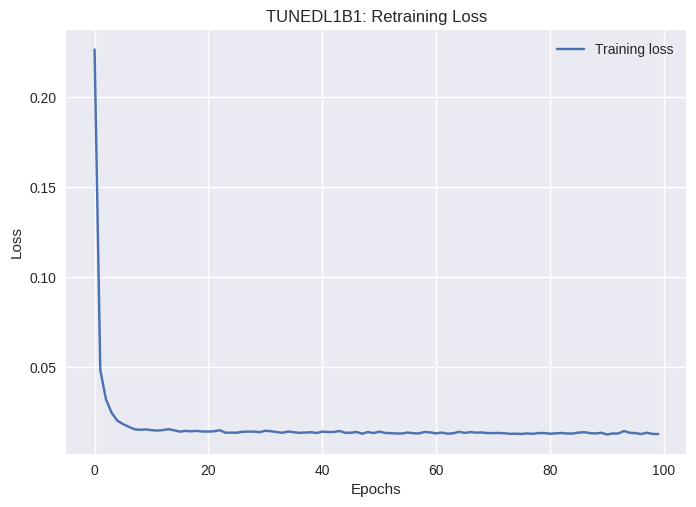

In [27]:
plt.plot(train_losses, label='Training loss')
plt.title('TUNEDL1B1: Retraining Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path+'TUNEDL1B1_Retrain_Loss.png', dpi = 300, transparent = True) 
plt.show()
plt.close()

In [28]:
# Save model for re-use
model.save(path+'TUNEDL1B1.h5')


Just to make sure, the shapes of the predicted and true values are (80, 1) and (80, 1)

The RMSE is: 5.912436008453369

The MAPE is: 8.293956518173218


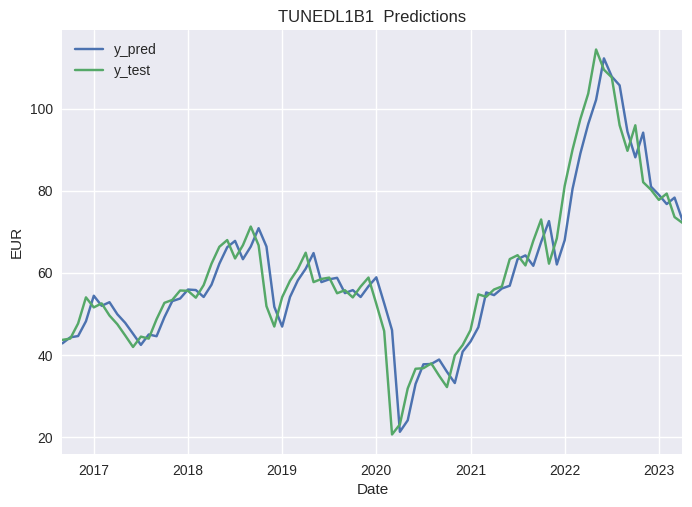

In [33]:
# Predictions on the test set
y_pred = model.predict(X_test, verbose = 0, batch_size = batch_size)

# Reverse scalings
y_pred = scaler.inverse_transform(y_pred)
y_test_unsc = scaler.inverse_transform(y_test)

# Check shapes just in case.
print(f'\nJust to make sure, the shapes of the predicted and true values are {y_pred.shape} and {y_test_unsc.shape}')
print(f'\nThe RMSE is: {rmse(y_test_unsc, y_pred)}')
print(f'\nThe MAPE is: {mape(y_test_unsc, y_pred)}')


# Plot
test_dates = dates[-len(y_test):]
df = pd.DataFrame({'y_pred': y_pred.flatten(), 'y_test': y_test_unsc.flatten()})
df.set_index(test_dates, inplace = True)
df.plot()
plt.title('TUNEDL1B1  Predictions') # Rename
plt.savefig(path+'TUNEDL1B1_Forecast.png', transparent = True, dpi = 300) # Rename
plt.ylabel('EUR') # copy
plt.show()
plt.close()

In [31]:
with open(path+'TUNEDL1B1_Results.pkl', 'wb') as f: # Rename
    pickle.dump(df, f)

In [32]:
# In sample predictions
ins = model.predict(X_retrain, verbose = 0, batch_size = batch_size)

# Reverse scalings
ins = scaler.inverse_transform(ins)
ins_true = scaler.inverse_transform(y_retrain)

# Check shapes just in case.
print(f'\nJust to make sure, the shapes of the predicted and true values are {ins.shape} and {ins_true.shape}')
print(f'\nThe RMSE is: {rmse(ins_true, ins)}')
print(f'\nThe MAPE is: {mape(ins_true, ins)}')


Just to make sure, the shapes of the predicted and true values are (321, 1) and (321, 1)

The RMSE is: 3.602389335632324

The MAPE is: 9.668469429016113
